In [ ]:
#mount with drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#import all require library
import os
from glob import glob #glob (short for global) is used to return all file paths that match a specific pattern
import shutil #shutil module offers a number of high-level operations on files and collections of files.
import random
import cv2
from PIL import Image
import numpy as np
from keras import layers
from tensorflow.keras.applications import ResNet50, DenseNet201
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
import tensorflow as tf
from keras import backend as K
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import json
import itertools
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from __future__ import print_function
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten,BatchNormalization,Activation


In [ ]:
#load the dataset
def Dataset_loader(DIR, RESIZE, sigmaX=10):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)
        _, ftype = os.path.splitext(PATH)
        if ftype == ".png":
            img = read(PATH)
           
            img = cv2.resize(img, (RESIZE,RESIZE))
           
            IMG.append(np.array(img))
    return IMG


In [ ]:
benign_train = np.array(Dataset_loader('/content/drive/MyDrive/breastcancer/train/benign',224))
malign_train = np.array(Dataset_loader('/content/drive/MyDrive/breastcancer/train/malignant',224))
benign_test = np.array(Dataset_loader('/content/drive/MyDrive/breastcancer/test/benign',224))
malign_test = np.array(Dataset_loader('/content/drive/MyDrive/breastcancer/test/malignant',224))

In [ ]:
#label for binary classes
benign_train_label = np.zeros(len(benign_train))
malign_train_label = np.ones(len(malign_train))
benign_test_label = np.zeros(len(benign_test))
malign_test_label = np.ones(len(malign_test))

In [ ]:
X_train = np.concatenate((benign_train, malign_train), axis = 0)
Y_train = np.concatenate((benign_train_label, malign_train_label), axis = 0)
X_test = np.concatenate((benign_test, malign_test), axis = 0)
Y_test = np.concatenate((benign_test_label, malign_test_label), axis = 0)

In [ ]:
X_train[0].shape

(224, 224, 3)

In [ ]:
# shuffling of binary classes
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]
s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]

In [ ]:
#convert the labels into categorical format.
Y_train = to_categorical(Y_train, num_classes= 2)
Y_test = to_categorical(Y_test, num_classes= 2)

In [ ]:
Y_train.shape

(2000, 2)

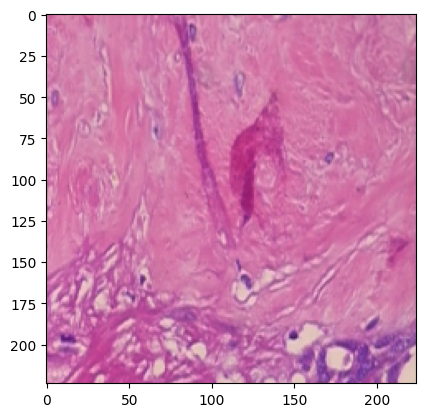

In [ ]:
sample = 1
image = X_train[sample]
# plot the sample
fig = plt.figure
plt.imshow(image, cmap='gray')
plt.show()

In [ ]:
#I split the data-set into two sets — train and validation sets with 80% and 20% images respectively
x_train, x_val, y_train, y_val = train_test_split(
    X_train, Y_train, 
    test_size=0.2, 
    random_state=11
)

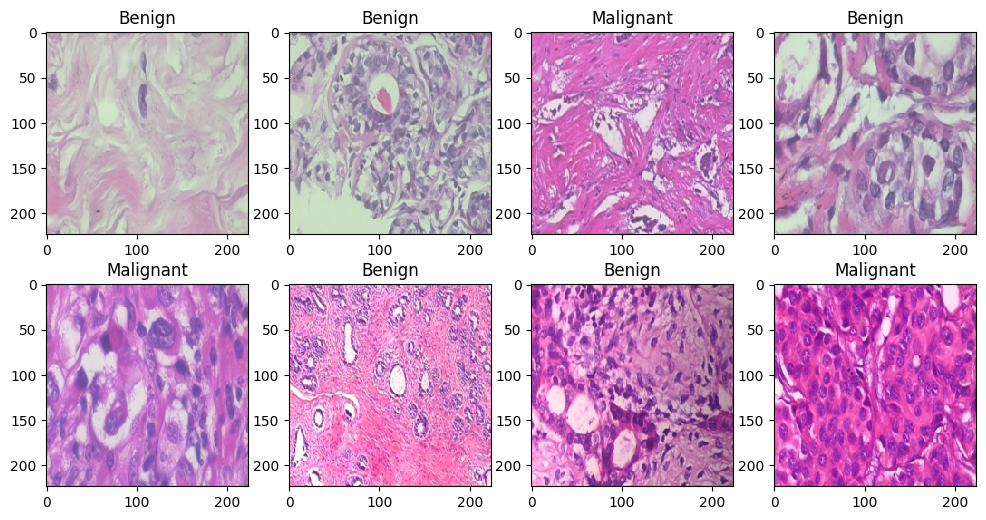

In [ ]:
# train dataset samples
w=60
h=40
fig=plt.figure(figsize=(12, 6))
columns = 4
rows = 2

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if np.argmax(y_train[i]) == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(x_train[i], interpolation='nearest')
plt.show()

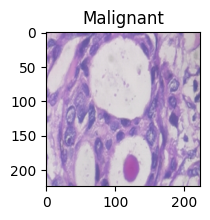

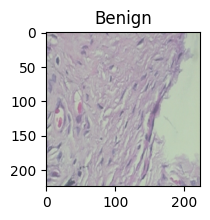

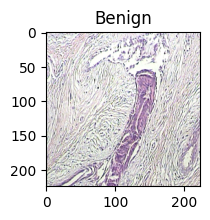

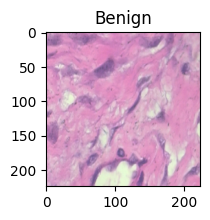

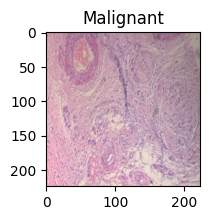

In [ ]:
for i in range(0,5):
  if np.argmax(Y_train[i])==0:
     label='Benign'
  else:
     label='Malignant'
  fig=plt.figure(figsize=(2, 2))
  fig = plt.figure
  plt.imshow(X_train[i], cmap='gray')
  plt.title(label)
  plt.show()

In [ ]:
BATCH_SIZE = 16
#The ImageDataGenerator class allows your model to receive new variations of the images at each epoch
train_generator = ImageDataGenerator(
        zoom_range=2,  
        rotation_range = 90,
        horizontal_flip=True,  
        vertical_flip=True,  
    )

In [ ]:
def create_model(lr=0.001):
  model=Sequential()
  model.add(Conv2D(32, (3, 3), padding='same',activation='relu',input_shape=(224,224,3)))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(3,3),strides=3,padding='valid'))
  model.add(Conv2D(64,(3,3),padding='same',activation='relu'))
  model.add(BatchNormalization())
  model.add(Conv2D(128,(3,3),padding='same',activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))
  model.add(Dropout(0.25))
  model.add(Conv2D(256,(3,3),padding='same',activation='relu'))
  model.add(BatchNormalization())
  model.add(Conv2D(512,(3,3),padding='same',activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))
  model.add(Dropout(0.25))
  model.add(Flatten())
  model.add(Dense(256,activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  model.add(Dense(2,activation='softmax'))
  model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=lr),
        metrics=['accuracy']
    )
  return model
model=create_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 batch_normalization_1 (Batc  (None, 224, 224, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 74, 74, 64)        18496     
                                                                 
 batch_normalization_2 (Batc  (None, 74, 74, 64)       256       
 hNormalization)                                                 
                                                      

In [ ]:
#Reduce learning rate used when a metric has stopped improving
learn_control = ReduceLROnPlateau(monitor='val_accuracy', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-5)

In [ ]:
#Checkpoints used during training model, it store in non-volatile memory.
filepath="model1_weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [ ]:
history = model.fit(
    train_generator.flow(x_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
    epochs=10,
    validation_data=(x_val, y_val),
    callbacks=[learn_control,checkpoint]
)

Epoch 1/10
100/100 [==============================] - ETA: 0s - loss: 0.6534 - accuracy: 0.7419
Epoch 1: val_accuracy improved from -inf to 0.48000, saving model to model1_weights.best.hdf5
100/100 [==============================] - 796s 8s/step - loss: 0.6534 - accuracy: 0.7419 - val_loss: 3.1591 - val_accuracy: 0.4800 - lr: 0.0010
Epoch 2/10
100/100 [==============================] - ETA: 0s - loss: 0.5331 - accuracy: 0.7531
Epoch 2: val_accuracy improved from 0.48000 to 0.63250, saving model to model1_weights.best.hdf5
100/100 [==============================] - 777s 8s/step - loss: 0.5331 - accuracy: 0.7531 - val_loss: 0.8831 - val_accuracy: 0.6325 - lr: 0.0010
Epoch 3/10
100/100 [==============================] - ETA: 0s - loss: 0.5333 - accuracy: 0.7469
Epoch 3: val_accuracy did not improve from 0.63250
100/100 [==============================] - 780s 8s/step - loss: 0.5333 - accuracy: 0.7469 - val_loss: 0.9178 - val_accuracy: 0.5050 - lr: 0.0010
Epoch 4/10
100/100 [===============

In [ ]:
model.load_weights("model1_weights.best.hdf5")

In [ ]:
Y_val_pred = model.predict(x_val)
accuracy_score(np.argmax(y_val, axis=1), np.argmax(Y_val_pred, axis=1))

13/13 [==============================] - 47s 3s/step


0.8225

In [ ]:
Y_pred = model.predict(X_test)

16/16 [==============================] - 73s 4s/step


In [ ]:
accuracy_score(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))

0.834

In [ ]:
from sklearn.metrics import classification_report
print(classification_report( np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1)))

              precision    recall  f1-score   support

           0       0.89      0.76      0.82       250
           1       0.79      0.91      0.85       250

    accuracy                           0.83       500
   macro avg       0.84      0.83      0.83       500
weighted avg       0.84      0.83      0.83       500



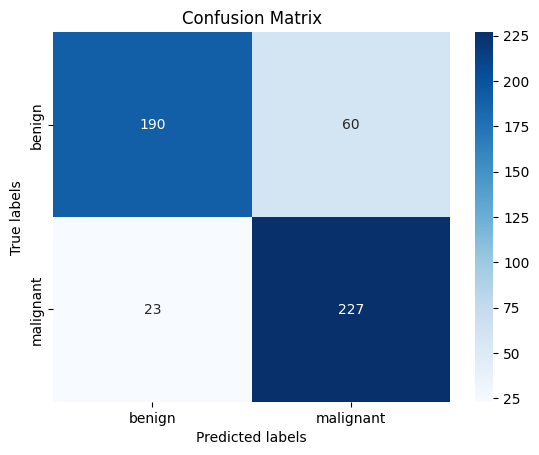

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=['benign', 'malignant'], yticklabels=['benign', 'malignant'])

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

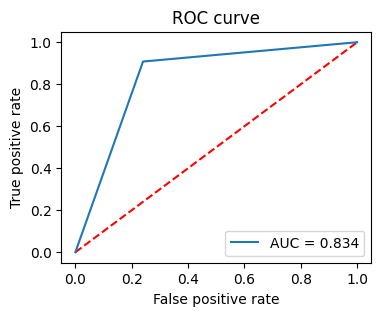

In [ ]:
from sklearn.metrics import roc_auc_score, auc
from sklearn.metrics import roc_curve
roc_log = roc_auc_score(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))
false_positive_rate, true_positive_rate, threshold = roc_curve(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))
area_under_curve = auc(false_positive_rate, true_positive_rate)

fig = plt.figure(figsize=(4,3))
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(false_positive_rate, true_positive_rate, label='AUC = {:.3f}'.format(area_under_curve))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()


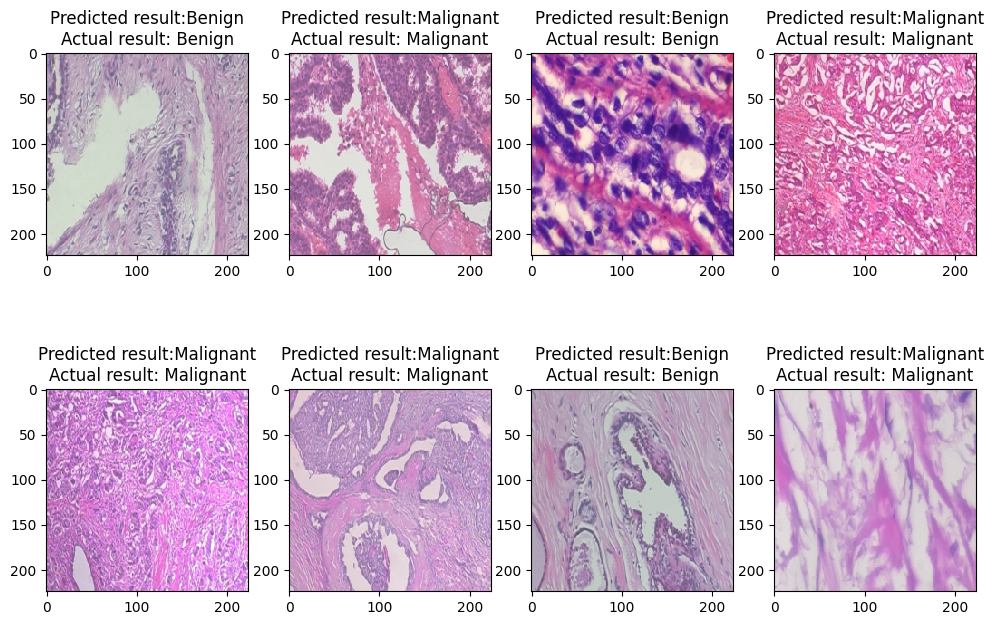

In [ ]:
i=0
prop_class=[]
mis_class=[]

for i in range(len(Y_test)):
    if(np.argmax(Y_test[i])==np.argmax(Y_pred[i])):
        prop_class.append(i)
    if(len(prop_class)==8):
        break

i=0
for i in range(len(Y_test)):
    if(not np.argmax(Y_test[i])==np.argmax(Y_pred[i])):
        mis_class.append(i)
    if(len(mis_class)==8):
        break

w=60
h=40
fig=plt.figure(figsize=(12, 8))
columns = 4
rows = 2

def Transfername(namecode):
    if namecode==0:
        return "Benign"
    else:
        return "Malignant"
    
for i in range(len(prop_class)):
    ax = fig.add_subplot(rows, columns, i+1)
    ax.set_title("Predicted result:"+ Transfername(np.argmax(Y_pred[prop_class[i]]))
                       +"\n"+"Actual result: "+ Transfername(np.argmax(Y_test[prop_class[i]])))
    plt.imshow(X_test[prop_class[i]], interpolation='nearest')
plt.show()

RESNET 50

In [ ]:
BATCH_SIZE = 16
#The ImageDataGenerator class allows your model to receive new variations of the images at each epoch
train_generator = ImageDataGenerator(
        zoom_range=2,  
        rotation_range = 90,
        horizontal_flip=True,  
        vertical_flip=True,  
    )

In [ ]:
def build_model(backbone, lr=1e-4):
    model = Sequential()
    model.add(backbone)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(2, activation='softmax'))
    
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=lr),
        metrics=['accuracy']
    )
    
    return model

In [ ]:
K.clear_session()
#This module provides an interface to the optional garbage collector
gc.collect()

#ResNet-50 is a convolutional neural network that is 50 layers deep.(48 convolutional layers, one MaxPool layer, and one average pool layer)
resnet = ResNet50(
    weights='imagenet', #"imagenet" indicates that we want to use the pre-trained ImageNet weights for the respective model. 
    include_top=False,#`include_top=False`means not interested in the last layer of the model.Excluding the top layers is important for feature extraction.
    input_shape=(224,224,3)
)

model = build_model(resnet ,lr = 1e-4)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 batch_normalization (BatchN  (None, 2048)             8192      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 2)                 4098      
                                                                 
Total params: 23,600,002
Trainable params: 23,542,786
No

In [ ]:
learn_control = ReduceLROnPlateau(monitor='val_accuracy', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)

In [ ]:
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [ ]:
history = model.fit(
    train_generator.flow(x_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
    epochs=10,
    validation_data=(x_val, y_val),
    callbacks=[learn_control, checkpoint]
)

Epoch 1/10
100/100 [==============================] - ETA: 0s - loss: 0.5591 - accuracy: 0.7613 
Epoch 1: val_accuracy improved from -inf to 0.50500, saving model to weights.best.hdf5
100/100 [==============================] - 1425s 14s/step - loss: 0.5591 - accuracy: 0.7613 - val_loss: 4.1253 - val_accuracy: 0.5050 - lr: 1.0000e-04
Epoch 2/10
100/100 [==============================] - ETA: 0s - loss: 0.4444 - accuracy: 0.8288 
Epoch 2: val_accuracy improved from 0.50500 to 0.59000, saving model to weights.best.hdf5
100/100 [==============================] - 1354s 14s/step - loss: 0.4444 - accuracy: 0.8288 - val_loss: 2.6709 - val_accuracy: 0.5900 - lr: 1.0000e-04
Epoch 3/10
100/100 [==============================] - ETA: 0s - loss: 0.4382 - accuracy: 0.8175 
Epoch 3: val_accuracy improved from 0.59000 to 0.73250, saving model to weights.best.hdf5
100/100 [==============================] - 1337s 13s/step - loss: 0.4382 - accuracy: 0.8175 - val_loss: 0.7500 - val_accuracy: 0.7325 - lr: 

In [ ]:
model.load_weights("weights.best.hdf5")

In [ ]:
Y_pred = model.predict(X_test)

16/16 [==============================] - 91s 6s/step


In [ ]:
from sklearn.metrics import classification_report
print(classification_report( np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1)))

              precision    recall  f1-score   support

           0       0.93      0.96      0.95       250
           1       0.96      0.93      0.95       250

    accuracy                           0.95       500
   macro avg       0.95      0.95      0.95       500
weighted avg       0.95      0.95      0.95       500



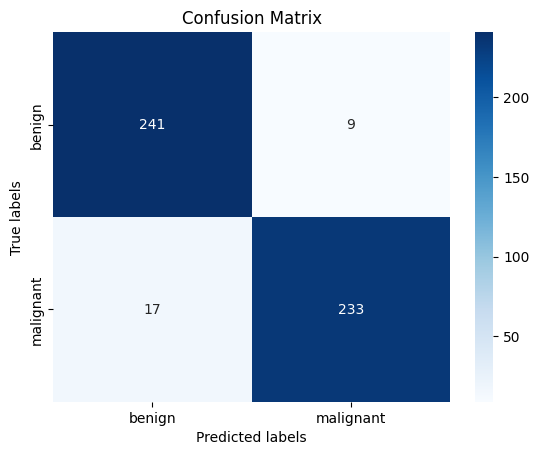

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=['benign', 'malignant'], yticklabels=['benign', 'malignant'])

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

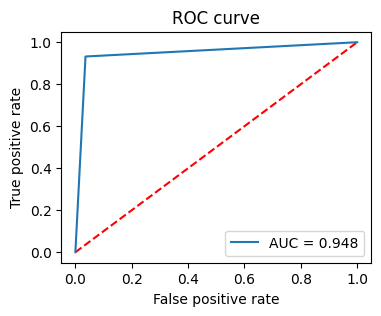

In [ ]:
from sklearn.metrics import roc_auc_score, auc
from sklearn.metrics import roc_curve
roc_log = roc_auc_score(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))
false_positive_rate, true_positive_rate, threshold = roc_curve(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))
area_under_curve = auc(false_positive_rate, true_positive_rate)

fig = plt.figure(figsize=(4,3))
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(false_positive_rate, true_positive_rate, label='AUC = {:.3f}'.format(area_under_curve))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

DENSENET201

In [ ]:
BATCH_SIZE = 16
train_generator = ImageDataGenerator(
        zoom_range=2,  
        rotation_range = 90,
        horizontal_flip=True,  
        vertical_flip=True,  
    )

In [ ]:
def build_model(backbone, lr=1e-4):
    model = Sequential()
    model.add(backbone)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(2, activation='softmax'))
    
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=lr),
        metrics=['accuracy']
    )
    
    return model

In [ ]:
K.clear_session()
gc.collect()

#DenseNet-201 is a convolutional neural network that is 201 layers deep. 
resnet = DenseNet201(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)

model = build_model(resnet ,lr = 1e-4)
model.summary()

74836368/74836368 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 global_average_pooling2d (G  (None, 1920)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1920)              0         
                                                                 
 batch_normalization (BatchN  (None, 1920)             7680      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 2)                 3842      
                                                         

In [ ]:
learn_control = ReduceLROnPlateau(monitor='val_accuracy', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)

In [ ]:
filepath="densenet_weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [ ]:
history = model.fit(
    train_generator.flow(x_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
    epochs=10,
    validation_data=(x_val, y_val),
    callbacks=[learn_control, checkpoint]
)

Epoch 1/10
100/100 [==============================] - ETA: 0s - loss: 0.5008 - accuracy: 0.7781 
Epoch 1: val_accuracy improved from -inf to 0.77750, saving model to densenet_weights.best.hdf5
100/100 [==============================] - 2118s 20s/step - loss: 0.5008 - accuracy: 0.7781 - val_loss: 0.4812 - val_accuracy: 0.7775 - lr: 1.0000e-04
Epoch 2/10
100/100 [==============================] - ETA: 0s - loss: 0.3873 - accuracy: 0.8344 
Epoch 2: val_accuracy did not improve from 0.77750
100/100 [==============================] - 2146s 21s/step - loss: 0.3873 - accuracy: 0.8344 - val_loss: 1.1425 - val_accuracy: 0.7200 - lr: 1.0000e-04
Epoch 3/10
100/100 [==============================] - ETA: 0s - loss: 0.3483 - accuracy: 0.8581 
Epoch 3: val_accuracy improved from 0.77750 to 0.91750, saving model to densenet_weights.best.hdf5
100/100 [==============================] - 2121s 21s/step - loss: 0.3483 - accuracy: 0.8581 - val_loss: 0.2411 - val_accuracy: 0.9175 - lr: 1.0000e-04
Epoch 4/10

In [ ]:
model.load_weights("densenet_weights.best.hdf5")

In [ ]:
Y_pred = model.predict(X_test)

16/16 [==============================] - 124s 7s/step


In [ ]:
from sklearn.metrics import classification_report
print(classification_report( np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1)))

              precision    recall  f1-score   support

           0       0.93      0.94      0.93       250
           1       0.94      0.92      0.93       250

    accuracy                           0.93       500
   macro avg       0.93      0.93      0.93       500
weighted avg       0.93      0.93      0.93       500



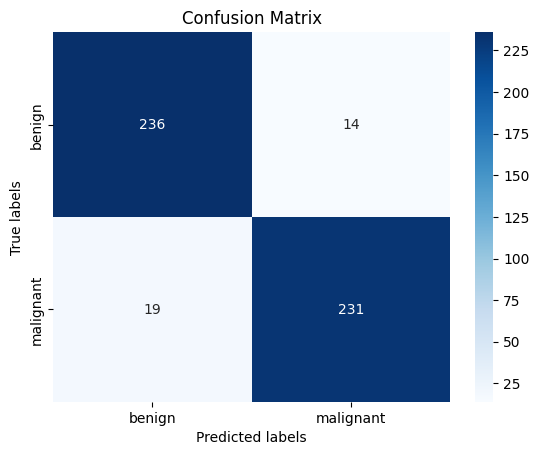

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=['benign', 'malignant'], yticklabels=['benign', 'malignant'])

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

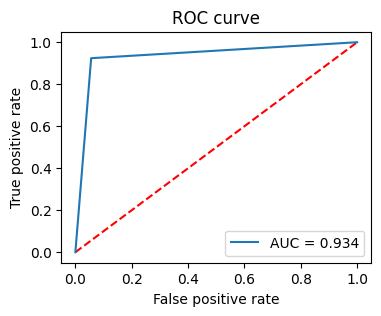

In [ ]:
from sklearn.metrics import roc_auc_score, auc
from sklearn.metrics import roc_curve
roc_log = roc_auc_score(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))
false_positive_rate, true_positive_rate, threshold = roc_curve(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))
area_under_curve = auc(false_positive_rate, true_positive_rate)

fig = plt.figure(figsize=(4,3))
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(false_positive_rate, true_positive_rate, label='AUC = {:.3f}'.format(area_under_curve))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

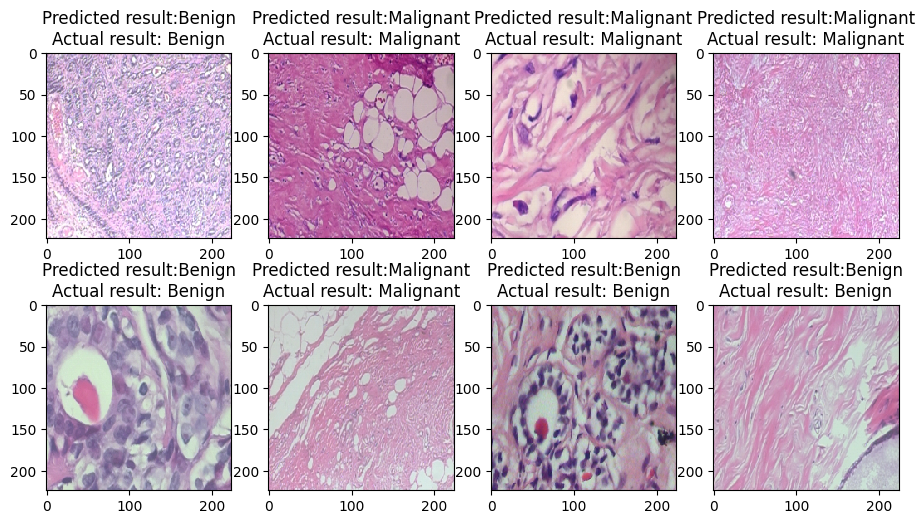

In [ ]:
i=0
prop_class=[]
mis_class=[]

for i in range(len(Y_test)):
    if(np.argmax(Y_test[i])==np.argmax(Y_pred[i])):
        prop_class.append(i)
    if(len(prop_class)==8):
        break

i=0
for i in range(len(Y_test)):
    if(not np.argmax(Y_test[i])==np.argmax(Y_pred[i])):
        mis_class.append(i)
    if(len(mis_class)==8):
        break

w=60
h=40
fig=plt.figure(figsize=(11, 6))
columns = 4
rows = 2

def Transfername(namecode):
    if namecode==0:
        return "Benign"
    else:
        return "Malignant"
    
for i in range(len(prop_class)):
    ax = fig.add_subplot(rows, columns, i+1)
    ax.set_title("Predicted result:"+ Transfername(np.argmax(Y_pred[prop_class[i]]))
                       +"\n"+"Actual result: "+ Transfername(np.argmax(Y_test[prop_class[i]])))
    plt.imshow(X_test[prop_class[i]], interpolation='nearest')